In [311]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup, SoupStrainer
import requests
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from fake_useragent import UserAgent
import time
import csv
import seaborn as sns
import re

### Scraping beers and links

In [347]:
#scraping beer names and links
links = {"Beer" : [],
        "url" : []}

#iterating through url format
for i in tqdm_notebook(range(0,101,50)):

    url = "https://www.beeradvocate.com/beer/styles/98/?sort=revsD&start={}".format(i)
    r = requests.get(url)
    soup = BeautifulSoup(r.text)

    #adding beer name and link to page
    for item in soup.find_all("tr")[3:-1]:
        try:
            links["Beer"].append(item.find("a").text)
        except:
            links["Beer"].append(np.nan)

        try:
            links["url"].append("https://www.beeradvocate.com/{}".format(item.find("a")["href"]))
        except:
            links["url"].append(np.nan)
        

In [348]:
pd.DataFrame(links).head()

,Beer,url
0,Honker's Ale,https://www.beeradvocate.com//beer/profile/114...
1,Fuller's London Pride,https://www.beeradvocate.com//beer/profile/71/...
2,Bluebird Bitter,https://www.beeradvocate.com//beer/profile/298...
3,Spitfire Premium Kentish Ale,https://www.beeradvocate.com//beer/profile/138...
4,Younger's Special Bitter,https://www.beeradvocate.com//beer/profile/132...


In [349]:
pd.DataFrame(links).to_csv("../../data/urls/urls_english_bitter.csv", index=False)

In [350]:
pd.read_csv("../../data/urls/urls_english_bitter.csv").head()

,Beer,url
0,Honker's Ale,https://www.beeradvocate.com//beer/profile/114...
1,Fuller's London Pride,https://www.beeradvocate.com//beer/profile/71/...
2,Bluebird Bitter,https://www.beeradvocate.com//beer/profile/298...
3,Spitfire Premium Kentish Ale,https://www.beeradvocate.com//beer/profile/138...
4,Younger's Special Bitter,https://www.beeradvocate.com//beer/profile/132...


### Scraping one page of reviews

In [227]:
url = "https://www.beeradvocate.com//beer/profile/1146/1157/?view=beer&sort=&start={}".format(0)
r = requests.get(url)
soup = BeautifulSoup(r.text)

b_id=url.split("/")[-2]

#finding beer name and brewer
name = soup.find("div", class_="titleBar").h1.find(text=True, recursive=False)
brewer = soup.find("div", class_="titleBar").span.text

#accessing stats
stats = soup.find_all("dd", class_="beerstats")
style = stats[0].b.text
abv = stats[1].b.text
rank = stats[2].b.text
av_rating = stats[3].b.text

#getting BA review/rating nums
n_reviews = soup.find("span", class_ = "ba-reviews Tooltip").text
n_ratings = soup.find("span", class_ = "ba-ratings Tooltip").text

#brewer's description
try:
    notes = soup.find("div", style= "clear:both; margin:0; padding:0px 20px; font-size:1.05em;").text.strip("Notes:\n")[:-1]
except:
    notes = np.nan
    
beers = {"id" : b_id, "name" : name, "brewer" : brewer, "style" : style,
         "abv" : abv, "rank" : rank, "av_rating" : av_rating, 
         "n_reviews" : n_reviews, "n_ratings" : n_ratings, "desc" : notes}


#creating lists for review scrape    
rating = []
look = []
smell = []
taste = []
feel = []
overall = []
review = []
date = []


#iterating through reviews
for rev in soup.find_all("div", class_="user-comment"):
    rating.append(rev.find("span", class_="BAscore_norm").text)
    
    #pulling out detailed ratings (if statement accounts for when user rating == average rating):
    if rev.find("span", class_="BAscore_norm").text == av_rating:
        details = [d.split(" ")[1] for d in rev.find_all("span", class_="muted")[1].text.split(" | ")]
    
    else:
        details = [d.split(" ")[1] for d in rev.find("span", class_="muted").text.split(" | ")]
        
    look.append(details[0])
    smell.append(details[1])
    taste.append(details[2])
    feel.append(details[3])
    overall.append(details[4])
    
    #review text
    text = str(rev.find("div", attrs={"id": "rating_fullview_content_2"})).split("<br/>")[3:-4]
    review.append("".join(text))
    
    date.append(rev.find_all("a")[2].text)
    
reviews = {"rating" : rating, "look" : look, "smell" : smell, "taste" : taste,
          "feel" : feel, "overall" : overall, "review" : review, "date" : date}

rev_df = pd.DataFrame(reviews)

rev_df["id"] = b_id
rev_df["name"] = name


In [228]:
pd.DataFrame(beers, index=[0])

,id,name,brewer,style,abv,rank,av_rating,n_reviews,n_ratings,desc
0,1157,Honker's Ale,Goose Island Beer Co.,English Bitter,4.3%,83,3.67,"1,140","3,971","Golden sunset color, fruity hop aroma, biscuit..."


In [229]:
rev_df.head()

,rating,look,smell,taste,feel,overall,review,date,id,name
0,3.62,4.25,3.5,3.5,3.75,3.75,From notes 3/31/13: Pours clear medium amber p...,"Jan 04, 2019",1157,Honker's Ale
1,4.06,4,4.25,4,4,4,It's funny that the best English Bitter that I...,"Dec 17, 2018",1157,Honker's Ale
2,3.93,3.75,3.75,4,4,4,12oz bottle dated 21SEP18 poured into my mouth...,"Dec 14, 2018",1157,Honker's Ale
3,4.35,4,4,4.75,4,4.25,Had this on tap when we went for dinner. I was...,"Aug 19, 2018",1157,Honker's Ale
4,3.27,3.5,3.25,3.25,3.25,3.25,As a fan of their IPA thought I would give Hon...,"Aug 18, 2018",1157,Honker's Ale


### Scraping many pages of one beer

In [254]:
#creating lists for review scrape    
rating, look, smell, taste, feel, overall, review, date = [],[],[],[],[],[],[],[]

#checking for first page:
p=0

for i in tqdm_notebook(range(0,101,25)):    
    
    url = "https://www.beeradvocate.com//beer/profile/1146/1157/?view=beer&sort=&start={}".format(i)
    r = requests.get(url)
    soup = BeautifulSoup(r.text)

    #if first page, get details about the beer
    if p==0:

        b_id=url.split("/")[-2]

        #finding beer name and brewer
        name = soup.find("div", class_="titleBar").h1.find(text=True, recursive=False)
        brewer = soup.find("div", class_="titleBar").span.text

        #accessing stats
        stats = soup.find_all("dd", class_="beerstats")
        style = stats[0].b.text
        abv = stats[1].b.text
        rank = stats[2].b.text
        av_rating = stats[3].b.text

        #getting BA review/rating nums
        n_reviews = soup.find("span", class_ = "ba-reviews Tooltip").text
        n_ratings = soup.find("span", class_ = "ba-ratings Tooltip").text

        #brewer's description
        try:
            notes = soup.find("div", style= "clear:both; margin:0; padding:0px 20px; font-size:1.05em;").text.strip("Notes:\n")[:-1]
        except:
            notes = np.nan
        
        p=1

    #iterating through reviews
    for rev in soup.find_all("div", class_="user-comment"):
        rating.append(rev.find("span", class_="BAscore_norm").text)

    
        #pulling out detailed ratings (if statement accounts for when user rating == average rating):
        if rev.find("span", class_="BAscore_norm").text == av_rating:
            details = [d.split(" ")[1] for d in rev.find_all("span", class_="muted")[1].text.split(" | ")]
        else:
            details = [d.split(" ")[1] for d in rev.find("span", class_="muted").text.split(" | ")]

        #if no detailed reatings:
        if len(details) < 5:           
            look.append(np.nan)
            smell.append(np.nan)
            taste.append(np.nan)
            feel.append(np.nan)
            overall.append(np.nan)
            
            #review text:
            text = str(rev.find("div", attrs={"id": "rating_fullview_content_2"})).split("<br/>")[1:-4]
            review.append("".join(text))
        
        #if there are detailed ratings:
        else:
            look.append(details[0])
            smell.append(details[1])
            taste.append(details[2])
            feel.append(details[3])
            overall.append(details[4])

            #review text
            text = str(rev.find("div", attrs={"id": "rating_fullview_content_2"})).split("<br/>")[3:-4]
            review.append("".join(text))

        date.append(rev.find_all("a")[2].text)

    
beers = {"id" : b_id, "name" : name, "brewer" : brewer, "style" : style,
         "abv" : abv, "rank" : rank, "av_rating" : av_rating, 
         "n_reviews" : n_reviews, "n_ratings" : n_ratings, "desc" : notes}

reviews = {"rating" : rating, "look" : look, "smell" : smell, "taste" : taste,
          "feel" : feel, "overall" : overall, "review" : review, "date" : date}

rev_df = pd.DataFrame(reviews)

rev_df["id"] = b_id
rev_df["name"] = name


In [255]:
rev_df.tail()

,rating,look,smell,taste,feel,overall,review,date,id,name
120,3.15,2.5,3,3.25,3.25,3.25,Boring beer. Pours a light copper with very li...,"Nov 28, 2014",1157,Honker's Ale
121,3.75,NaN,NaN,NaN,NaN,NaN,Reminds me of a light brown ale or a Michelob ...,"Nov 13, 2014",1157,Honker's Ale
122,3.58,NaN,NaN,NaN,NaN,NaN,"A very nice, easy drinking beer. Pours a nice ...","Oct 24, 2014",1157,Honker's Ale
123,3.3,4,3.25,3.25,3.25,3.25,12 oz bottle into a pint glass.\n\nAppearance:...,"Oct 23, 2014",1157,Honker's Ale
124,4,NaN,NaN,NaN,NaN,NaN,I love bitter and cut my beer teeth in England...,"Sep 13, 2014",1157,Honker's Ale


### Scraping several pages for many different beers

In [363]:
#creating lists for beer details
b_id, name, brewer, style, abv, rank, av_rating, n_reviews, n_ratings, desc = [],[],[],[],[],[],[],[],[],[]

#creating dataframe for reviews:
all_reviews = pd.DataFrame()


for beer in tqdm_notebook(pd.read_csv("../../data/urls/urls_english_bitter.csv")["url"]):
    
    #checking for first page:
    p=0

    #creating lists for review scrape    
    rating, look, smell, taste, feel, overall, review, date = [],[],[],[],[],[],[],[]
    
    for i in range(0,101,25):    

        url = beer+"?view=beer&sort=&start={}".format(i)
        r = requests.get(url)
        soup = BeautifulSoup(r.text)

        #if first page, get details about the beer
        if p==0:

            beer_id = url.split("/")[-2]
            b_id.append(beer_id)

            #finding beer name and brewer
            beer_name = soup.find("div", class_="titleBar").h1.find(text=True, recursive=False)
            name.append(beer_name)
            brew_name = soup.find("div", class_="titleBar").span.text
            brewer.append(brew_name)

            #accessing stats
            stats = soup.find_all("dd", class_="beerstats")
            try:
                style.append(stats[0].b.text)
            except:
                style.append(np.nan)
            try:
                abv.append(stats[1].b.text)
            except:
                abv.append(np.nan)
            try:
                rank.append(stats[2].b.text)
            except:
                rank.append(np.nan)  
            try:
                av_rating.append(stats[3].b.text)
            except:
                av_rating.append(np.nan)
                

            #getting BA review/rating nums
            n_reviews.append(soup.find("span", class_ = "ba-reviews Tooltip").text)
            n_ratings.append(soup.find("span", class_ = "ba-ratings Tooltip").text)

            #brewer's description
            try:
                notes = soup.find("div", style= "clear:both; margin:0; padding:0px 20px; font-size:1.05em;").text.strip("Notes:\n")[:-1]
                desc.append(re.sub(r"\n+", " ", notes))    
                            
            except:
                desc.append(np.nan)

            p=1

        #iterating through reviews
        for rev in soup.find_all("div", class_="user-comment"):
            rating.append(rev.find("span", class_="BAscore_norm").text)


            #pulling out detailed ratings (if statement accounts for when user rating == average rating):
            if rev.find("span", class_="BAscore_norm").text == av_rating:
                details = [d.split(" ")[1] for d in rev.find_all("span", class_="muted")[1].text.split(" | ")]
            else:
                details = [d.split(" ")[1] for d in rev.find("span", class_="muted").text.split(" | ")]

            #if no detailed reatings:
            if len(details) < 5:           
                look.append(np.nan)
                smell.append(np.nan)
                taste.append(np.nan)
                feel.append(np.nan)
                overall.append(np.nan)

                #review text:
                text = str(rev.find("div", attrs={"id": "rating_fullview_content_2"})).split("<br/>")[1:-4]
                review.append("".join(text))

            #if there are detailed ratings:
            else:
                look.append(details[0])
                smell.append(details[1])
                taste.append(details[2])
                feel.append(details[3])
                overall.append(details[4])

                #review text
                text = str(rev.find("div", attrs={"id": "rating_fullview_content_2"})).split("<br/>")[3:-4]
                review.append(re.sub(r"\n+", " ", "".join(text)))

            date.append(rev.find_all("a")[2].text)


    reviews = {"rating" : rating, "look" : look, "smell" : smell, "taste" : taste,
              "feel" : feel, "overall" : overall, "review" : review, "date" : date}

    rev_df = pd.DataFrame(reviews)

    rev_df["id"] = beer_id
    rev_df["name"] = beer_name
    
    all_reviews = pd.concat([all_reviews, rev_df])
        
    
beers = {"id" : b_id, "name" : name, "brewer" : brewer, "style" : style,
         "abv" : abv, "rank" : rank, "av_rating" : av_rating, 
         "n_reviews" : n_reviews, "n_ratings" : n_ratings, "desc" : desc}

beer_df = pd.DataFrame(beers)

all_reviews.reset_index(inplace=True)
all_reviews.drop(columns = ["index"], inplace=True)


In [396]:
beer_df.to_csv("../../data/beers.csv",index=False)
all_reviews.to_csv("../../data/reviews/english_bitters.csv", index=False)

In [377]:
beer_df.head()

,id,name,brewer,style,abv,rank,av_rating,n_reviews,n_ratings,desc
0,1157,Honker's Ale,Goose Island Beer Co.,English Bitter,4.3%,83,3.67,"1,140","3,971","Golden sunset color, fruity hop aroma, biscuit..."
1,222,Fuller's London Pride,Fuller Smith & Turner PLC,English Bitter,4.1%,88,3.94,"1,114","2,681","just the iconic ale of the capital, London Pr..."
2,828,Bluebird Bitter,Coniston Brewing Co. Ltd,English Bitter,4.2%,87,3.88,305,495,Bluebird is a fine session ale with a light go...
3,305,Spitfire Premium Kentish Ale,Shepherd Neame Ltd,English Bitter,4.5%,82,3.62,183,452,This 4.2% Kentish ale (bottle 4.5%) was first ...
4,2679,Younger's Special Bitter,Rogue Ales,English Bitter,4.8%,88,3.95,279,367,


In [367]:
all_reviews.tail()

,index,rating,look,smell,taste,feel,overall,review,date,id,name
4924,13,3.26,4,3,3.5,3,3,BBD: 1 Jan 2011 So this recently showed up aro...,"May 05, 2010",18650,Tawny Owl
4925,14,4.17,3.5,4,4,4,5,1st of the 3 Birds of Prey gift pack generousl...,"Feb 06, 2010",18650,Tawny Owl
4926,15,3.68,3.5,3,4,3.5,4,Tasted by half-pint recently at my local JDW p...,"Feb 08, 2006",18650,Tawny Owl
4927,0,4.17,4.25,4,4.25,4,4.25,Lovely clear amber brew with swirls of foam in...,"Mar 31, 2017",97307,Best Bitter
4928,1,3.95,3.75,3.75,4,4.25,4,Poured into a Seattle Beer Week pint glass. Po...,"Jul 30, 2013",97307,Best Bitter


In [369]:
#checking no. of reviews per beer
all_reviews["name"].value_counts()

Ruddles County                  125
Newcastle Summer Ale            125
Younger's Special Bitter        125
Hopback Summer Lightning        125
Spitfire Premium Kentish Ale    125
                               ... 
SB 604                            3
Hobgoblin 4.5%                    3
Piledriver                        2
Kilntym                           2
Pitch Penny Ale                   2
Name: name, Length: 144, dtype: int64

In [375]:
#searching for the best brewer
beer_df[beer_df["brewer"].str.contains("Harvey")]

,id,name,brewer,style,abv,rank,av_rating,n_reviews,n_ratings,desc
84,27758,Sussex Best Bitter,Harvey & Son Ltd.,English Bitter,4%,85,3.86,13,36,
101,7350,Best,Harvey & Son Ltd.,English Bitter,4%,86,3.91,15,29,


In [381]:
#searching for the best beer
all_reviews[all_reviews["id"] == "27758"]

,rating,look,smell,taste,feel,overall,review,date,id,name
4085,3.75,4.25,3,4,3.75,4,On draught at ‘The Crown’ pub in Little Missen...,"Sep 24, 2017",27758,Sussex Best Bitter
4086,2.86,3.5,3,2.75,2.75,2.75,"Cask pour at the Madison Pourhouse in Albany, ...","Feb 29, 2016",27758,Sussex Best Bitter
4087,4.97,4.5,5,5,5,5,At it's best a fabulous easy drinking session ...,"Jun 28, 2015",27758,Sussex Best Bitter
4088,4,4,4,4,4,4,Cask. Sparkling clear amber. Thin head. Good l...,"May 10, 2014",27758,Sussex Best Bitter
4089,4.03,4.5,4,4,4,4,Served hand-pulled at The Harp in London in an...,"Mar 28, 2011",27758,Sussex Best Bitter
4090,4.77,4.5,5,4.5,5,5,Wow. I'm obsessed with finding good bitters l...,"Jul 21, 2010",27758,Sussex Best Bitter
4091,4,3.5,3.5,4.5,3.5,4,"On cask at the White Horse Pub, Parsons Green,...","Jan 03, 2010",27758,Sussex Best Bitter
4092,3.28,3.5,3,3.5,3.5,3,Had a pint on cask at the Red Lyon in Slinfold...,"Sep 19, 2009",27758,Sussex Best Bitter
4093,4.15,4,4,4,4.5,4.5,Had a half pint on cask at The Harp near Trafa...,"Apr 21, 2009",27758,Sussex Best Bitter
4094,3.16,4,3,3,4,3,Pours a cloudy dark amber/ orange color with a...,"Nov 21, 2008",27758,Sussex Best Bitter


In [414]:
#some html ended up in the wrong place, so dropping those rows
all_reviews = all_reviews[all_reviews["overall"] != "overall:"]

C:\Users\James\Anaconda\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [410]:
floats = ["rating", "look", "smell", "taste", "feel", "overall"]

for col in floats:
    all_reviews[col] = all_reviews[col].astype(float)

C:\Users\James\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [417]:
#only including those dates that start with the "MMM " format
all_reviews = all_reviews[all_reviews["date"].str.contains(r"^[A-z]{3}\s")]

In [418]:
all_reviews["date"] = pd.to_datetime(all_reviews["date"])

In [438]:
#scrape ended up with some data in the wrong columns, only 100/5000 so happy to just drop
all_reviews = all_reviews[~all_reviews["review"].str.contains(r"^<span")]

In [444]:
#imputing missing detail values by using the overal rating
all_reviews = all_reviews.apply(lambda x: x.fillna(x[0]), axis=1)

In [445]:
all_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4874 entries, 0 to 4928
Data columns (total 10 columns):
rating     4874 non-null float64
look       4874 non-null float64
smell      4874 non-null float64
taste      4874 non-null float64
feel       4874 non-null float64
overall    4874 non-null float64
review     4874 non-null object
date       4874 non-null datetime64[ns]
id         4874 non-null object
name       4874 non-null object
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 418.9+ KB


In [450]:
all_reviews.describe()

,rating,look,smell,taste,feel,overall
count,4874.000000,4874.000000,4874.000000,4874.000000,4874.000000,4874.000000
mean,3.619532,3.754762,3.512302,3.612630,3.601705,3.727731
std,0.540676,0.527734,0.591372,0.630672,0.606153,0.658809
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.320000,3.500000,3.000000,3.500000,3.250000,3.500000
50%,3.680000,4.000000,3.500000,3.500000,3.500000,4.000000
75%,3.980000,4.000000,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


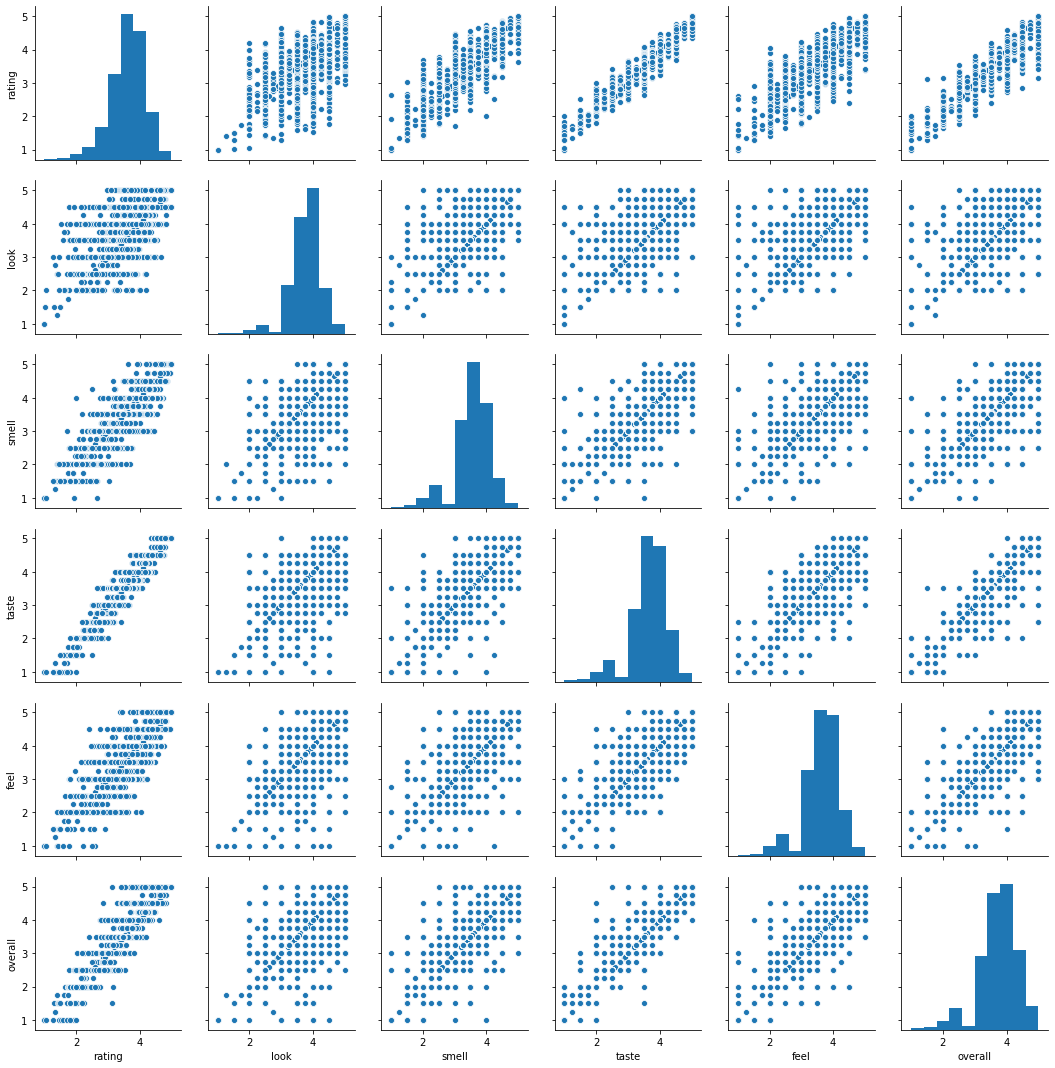

In [447]:
sns.pairplot(all_reviews.drop(columns=["id"]))
plt.show()

In [448]:
all_reviews.corr()

,rating,look,smell,taste,feel,overall
rating,1.000000,0.543871,0.826116,0.949438,0.793170,0.900016
look,0.543871,1.000000,0.433217,0.441742,0.485393,0.455680
smell,0.826116,0.433217,1.000000,0.680412,0.562864,0.646598
taste,0.949438,0.441742,0.680412,1.000000,0.710715,0.815109
feel,0.793170,0.485393,0.562864,0.710715,1.000000,0.710714
overall,0.900016,0.455680,0.646598,0.815109,0.710714,1.000000


In [449]:
all_reviews.to_csv("../../data/reviews/english_bitters_cleaned.csv", index=False)